In [3]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, LogLocator

# Load the JSON file
data = pd.read_json('../generated/VUEs.json')

# Convert to a DataFrame
df = pd.DataFrame(data)


# Normalize the 'revisedProteinEffects' column
normalized_dfs = []
for index, row in df.iterrows():
    normalized_row = pd.json_normalize(row['revisedProteinEffects'])
    repeated_row = pd.DataFrame([row.drop('revisedProteinEffects')] * len(normalized_row)).reset_index(drop=True)
    combined = pd.concat([repeated_row.reset_index(drop=True), normalized_row], axis=1).reset_index(drop=True)
    normalized_dfs.append(combined)

# Determine the union of all column names
all_columns = set()
for df in normalized_dfs:
    all_columns.update(df.columns)

# Reindex each DataFrame to include all columns, filling missing values with NaN
all_columns = list(all_columns)
for i, df in enumerate(normalized_dfs):
    normalized_dfs[i] = df.loc[:, ~df.columns.duplicated()].reindex(columns=all_columns)

# Concatenate all normalized DataFrames
result_df = pd.concat(normalized_dfs, ignore_index=True)
# make anything CountByVariantCount 0
count_cancer_type_columns = [col for col in result_df.columns if 'CountByCancerType' in col]
result_df[count_cancer_type_columns] = result_df[count_cancer_type_columns].fillna(0).astype(int)

In [4]:
# hardcoded set o fgene swith highest level (manually determined with
# mutationmapper, and just looking upn genes in OncoKB)
highest_level_per_gene = {
    "KIT": "Level 1",
    "MET": "Level 1",
    "FLT3": "Level 1",
    "ATM": "Level 1",
    "BRCA1": "Level 1",
    "BRCA2": "Level 1",
    "BRIP1": "Level 1",
    "CHEK2": "Level 1",
    "PALB2": "Level 1",
    "RAD51D": "Level 1",
    "MLH1": "Level 1",
    "EGFR": "Level 1",
}

In [5]:
result_df.columns

Index(['counts.mskimpact_nonsignedout.somaticVariantsCountByCancerType.Cancer of Unknown Primary',
       'counts.mskimpact.germlineVariantsCountByCancerType.Breast Cancer',
       'counts.genie.somaticVariantsCountByCancerType.Hepatobiliary Cancer',
       'counts.mskimpact.germlineVariantsCountByCancerType.Pancreatic Cancer',
       'counts.genie.somaticVariantsCountByCancerType.Prostate Cancer',
       'counts.mskimpact.germlineVariantsCountByCancerType.Small Bowel Cancer',
       'counts.tcga.totalPatientCount', 'otherVariation',
       'counts.mskimpact.germlineVariantsCountByCancerType.Cancer of Unknown Primary',
       'counts.mskimpact.germlineVariantsCountByCancerType.Non-Small Cell Lung Cancer',
       ...
       'genomicLocation',
       'counts.genie.somaticVariantsCountByCancerType.Melanoma',
       'counts.genie.somaticVariantsCountByCancerType.Ovarian Cancer',
       'counts.genie.unknownVariantsCountByCancerType.Non-Small Cell Lung Cancer',
       'counts.genie.somaticV

In [6]:

print(set([c for c in result_df.columns if "CancerType" in c]))

{'counts.mskimpact_nonsignedout.somaticVariantsCountByCancerType.Cancer of Unknown Primary', 'counts.mskimpact.germlineVariantsCountByCancerType.Breast Cancer', 'counts.mskimpact.germlineVariantsCountByCancerType.Pancreatic Cancer', 'counts.genie.somaticVariantsCountByCancerType.Hepatobiliary Cancer', 'counts.genie.somaticVariantsCountByCancerType.Prostate Cancer', 'counts.mskimpact.germlineVariantsCountByCancerType.Small Bowel Cancer', 'counts.mskimpact.germlineVariantsCountByCancerType.Cancer of Unknown Primary', 'counts.mskimpact.germlineVariantsCountByCancerType.Non-Small Cell Lung Cancer', 'counts.mskimpact.somaticVariantsCountByCancerType.Glioma', 'counts.ccle_broad_2019.unknownVariantsCountByCancerType.Small Cell Lung Cancer', 'counts.mskimpact_nonsignedout.somaticVariantsCountByCancerType.Prostate Cancer', 'counts.mskimpact.unknownVariantsCountByCancerType.Non-Small Cell Lung Cancer', 'counts.mskimpact.germlineVariantsCountByCancerType.Prostate Cancer', 'counts.mskimpact.somati

In [11]:
cancer_types = set([c.split('.')[-1] for c in result_df.columns if "CancerType" in c])
print(len(cancer_types))

39


In [12]:
# Custom function to calculate the sum
def custom_sum(row):
    result = {}
    for study in "tcga mskimpact mskimpact_nonsignedout genie ccle_broad_2019".split():
        result[study] = (
            row[f'counts.{study}.somaticVariantsCount'].sum() +
            row[f'counts.{study}.germlineVariantsCount'].sum() +
            row[f'counts.{study}.unknownVariantsCount'].sum()
        )
    for cancer_type in cancer_types:
        result[f'counts.CancerType.{cancer_type}'] = 0
        for study in "tcga mskimpact mskimpact_nonsignedout genie".split():
            result[f'counts.CancerType.{cancer_type}'] += (
                row.get(f'counts.{study}.somaticVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
                row.get(f'counts.{study}.germlineVariantsCountByCancerType.{cancer_type}', np.array(0)).sum() +
                row.get(f'counts.{study}.unknownVariantsCountByCancerType.{cancer_type}', np.array(0)).sum()
            )
    return pd.Series(result)

# Group by 'hugoGeneSymbol' and apply custom function
grouped_df = result_df.groupby('hugoGeneSymbol').apply(custom_sum)

# Add additional columns
grouped_df['Number of VUEs'] = result_df.groupby('hugoGeneSymbol').size()
grouped_df['total_variant_count'] = grouped_df['tcga mskimpact mskimpact_nonsignedout genie'.split()].sum(axis=1)
grouped_df['Highest_Level'] = grouped_df.index.map(highest_level_per_gene).fillna('Oncogenic')
grouped_df.head()

,tcga,mskimpact,mskimpact_nonsignedout,genie,ccle_broad_2019,counts.CancerType.Uterine Sarcoma,"counts.CancerType.Peritoneal Cancer, NOS","counts.CancerType.Skin Cancer, Non-Melanoma",counts.CancerType.Glioma,counts.CancerType.Miscellaneous Neuroepithelial Tumor,...,counts.CancerType.B-Lymphoblastic Leukemia/Lymphoma,counts.CancerType.Peripheral Nervous System,counts.CancerType.Colorectal Cancer,counts.CancerType.Thyroid Cancer,counts.CancerType.Small Cell Lung Cancer,counts.CancerType.Mesothelioma,counts.CancerType.Head and Neck Cancer,Number of VUEs,total_variant_count,Highest_Level
hugoGeneSymbol,,,,,,,,,,,,,,,,,,,,,
APC,0,1,321,0,0,0,0,0,0,0,...,0,0,317,0,0,0,0,1,322,Oncogenic
ATM,0,13,4,0,0,0,0,1,0,0,...,0,0,3,0,0,0,0,10,17,Level 1
BAP1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,Oncogenic
BRCA1,1,27,0,15,0,0,0,0,5,0,...,0,0,0,0,2,0,0,9,43,Level 1
BRCA2,0,7,2,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,9,10,Level 1


In [13]:
# TODO: BAP1 not found (should be in TCGA-B0-4842-01 but it's not there: https://cancer.sanger.ac.uk/cosmic/sample/overview?id=1779818)
# TODO: FLT3 is in heme 3 times (1 sample)
# TODO: RAD51D once in ccle_broad_2019
zero_variant_cases = grouped_df[grouped_df['total_variant_count'] == 0]
print("There are {} VUEs with 0 variants".format(len(zero_variant_cases)))
print(zero_variant_cases)

There are 0 VUEs with 0 variants
Empty DataFrame
Columns: [tcga, mskimpact, mskimpact_nonsignedout, genie, ccle_broad_2019, counts.CancerType.Uterine Sarcoma, counts.CancerType.Peritoneal Cancer, NOS, counts.CancerType.Skin Cancer, Non-Melanoma, counts.CancerType.Glioma, counts.CancerType.Miscellaneous Neuroepithelial Tumor, counts.CancerType.Endometrial Cancer, counts.CancerType.Melanoma, counts.CancerType.Hepatobiliary Cancer, counts.CancerType.Leukemia, counts.CancerType.Germ Cell Tumor, counts.CancerType.Pancreatic Cancer, counts.CancerType.Breast Cancer, counts.CancerType.Esophagogastric Cancer, counts.CancerType.Gastrointestinal Stromal Tumor, counts.CancerType.Cancer of Unknown Primary, counts.CancerType.Tubular Adenoma of the Colon, counts.CancerType.Retinoblastoma, counts.CancerType.Renal Cell Carcinoma, counts.CancerType.Adrenocortical Carcinoma, counts.CancerType.Small Bowel Cancer, counts.CancerType.Gastrointestinal Neuroendocrine Tumor, counts.CancerType.Bladder Cancer, co

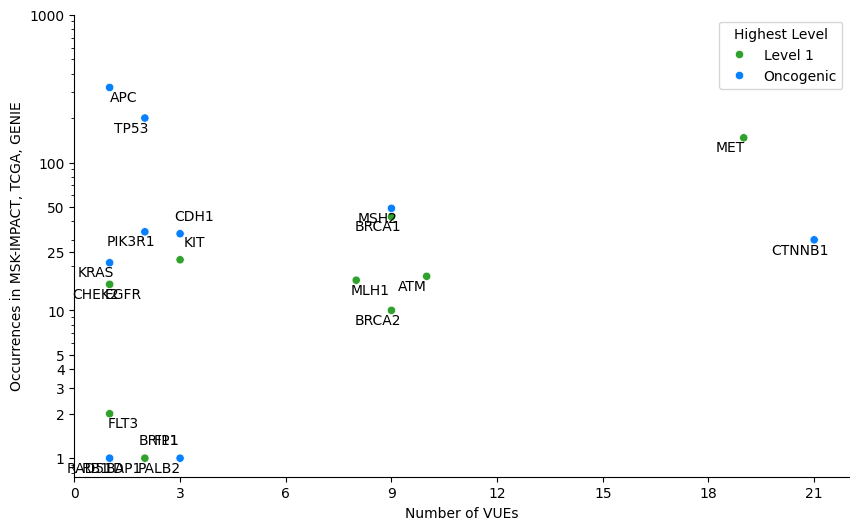

In [62]:
from matplotlib.ticker import MaxNLocator, LogLocator, ScalarFormatter

# Create the scatter plot
plt.figure(figsize=(10, 6))


palette = {"Level 1": "#30A12D", "Oncogenic": "#0780FE"}

scatter_plot = sns.scatterplot(data=grouped_df, x='Number of VUEs', y='total_variant_count', hue="Highest_Level", palette=palette)

# Despine the plot
sns.despine()

# Set x-axis to display integers only
scatter_plot.xaxis.set_major_locator(MaxNLocator(integer=True))
# Set y-axis to log scale
scatter_plot.set_yscale('log')
# Manually set y-axis ticks
scatter_plot.set_yticks([1, 2, 3, 4, 5, 10, 25, 50, 100, 1000])
scatter_plot.get_yaxis().set_major_formatter(ScalarFormatter())


# Add labels and title
scatter_plot.set_xlabel('Number of VUEs')
scatter_plot.set_ylabel('Occurrences in MSK-IMPACT, TCGA, GENIE')

# Reorder the legend handles and labels
handles, labels = scatter_plot.get_legend_handles_labels()
handles = [handles[1], handles[0]]  # Swap the order of handles
labels = [labels[1], labels[0]]  # Swap the order of labels
# Update the legend
scatter_plot.legend(handles, labels, title="Highest Level", loc="upper right")

# Add annotations for each point with gene symbols
texts = []
for i, row in grouped_df.iterrows():
    # Add some randomness to the initial text position
    x_offset = np.random.choice([-10,10])
    y_offset = np.random.choice([10, -10])
    texts.append(scatter_plot.annotate(row.name, 
                          (row['Number of VUEs'], row['total_variant_count']),
                          textcoords="offset points", xytext=(x_offset, y_offset), ha='center', fontsize=10))

# Show the plot
plt.show()

In [15]:
cancer_type_counts = pd.read_csv('./cancer_type_revue_counts.txt', sep='\t').groupby('Cancer Type')['Patient ID'].nunique()
cancer_type_counts.head()

Cancer Type
Acute myeloid leukemia       16
Adenocarcinoma In Situ        4
Adrenal Gland Cancer          2
Adrenocortical Adenoma        6
Adrenocortical Carcinoma    212
Name: Patient ID, dtype: int64

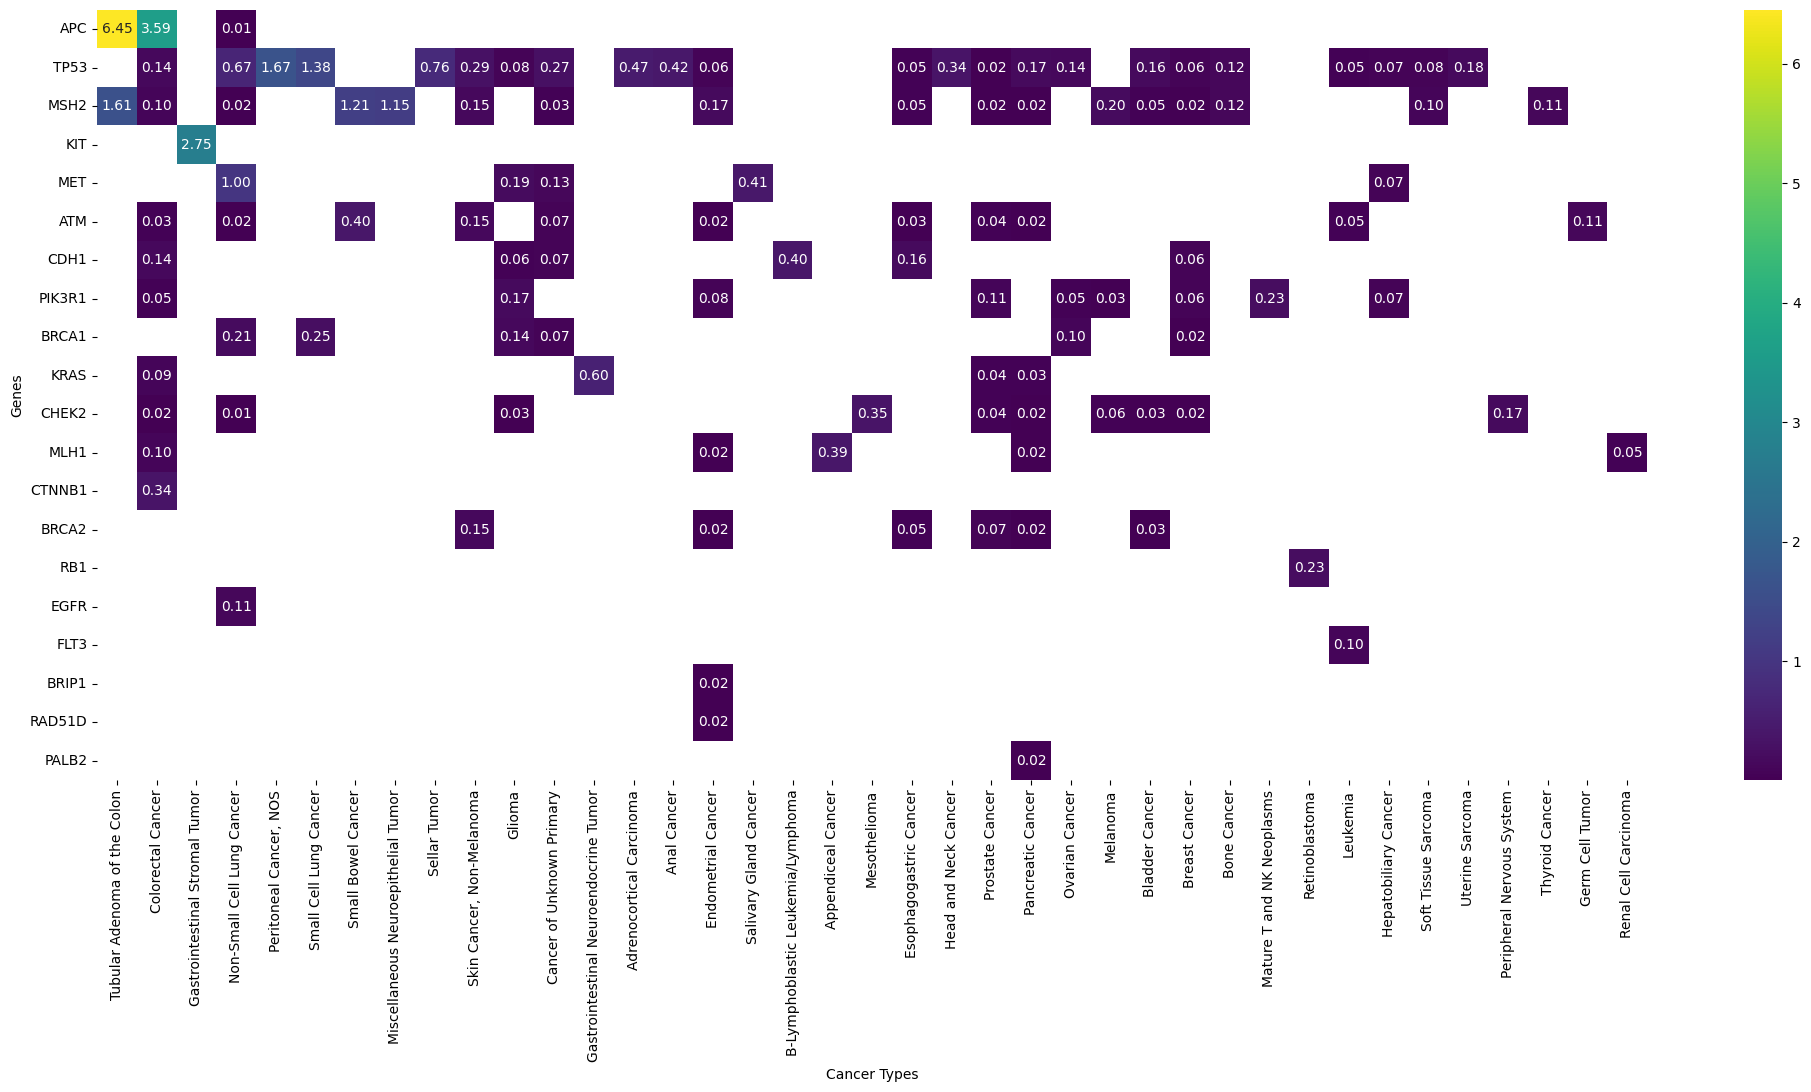

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming grouped_df is already created and contains the necessary data

# Extract the relevant columns for the heatmap
heatmap_data = grouped_df.filter(like='counts.CancerType')
heatmap_data.columns = [col.replace('counts.CancerType.', '') for col in heatmap_data.columns]

# Pivot the DataFrame to have genes as columns and cancer types as rows
heatmap_data = heatmap_data

# Filter out rows that sum up to 0
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) != 0]

# Normalize the counts by the total counts for each cancer type using cancer_type_counts
for col in heatmap_data.columns:
    heatmap_data[col] = heatmap_data[col] * 100.0 / cancer_type_counts.loc[col]

# Sort the rows and columns by the sum of their values
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
heatmap_data = heatmap_data[heatmap_data.sum(axis=0).sort_values(ascending=False).index]

# Create a mask for cells that are 0
mask = heatmap_data == 0

# Plot the heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.2f', mask=mask)
# plt.title('Heatmap of Genes vs Cancer Types')
plt.xlabel('Cancer Types')
plt.ylabel('Genes')
plt.show()

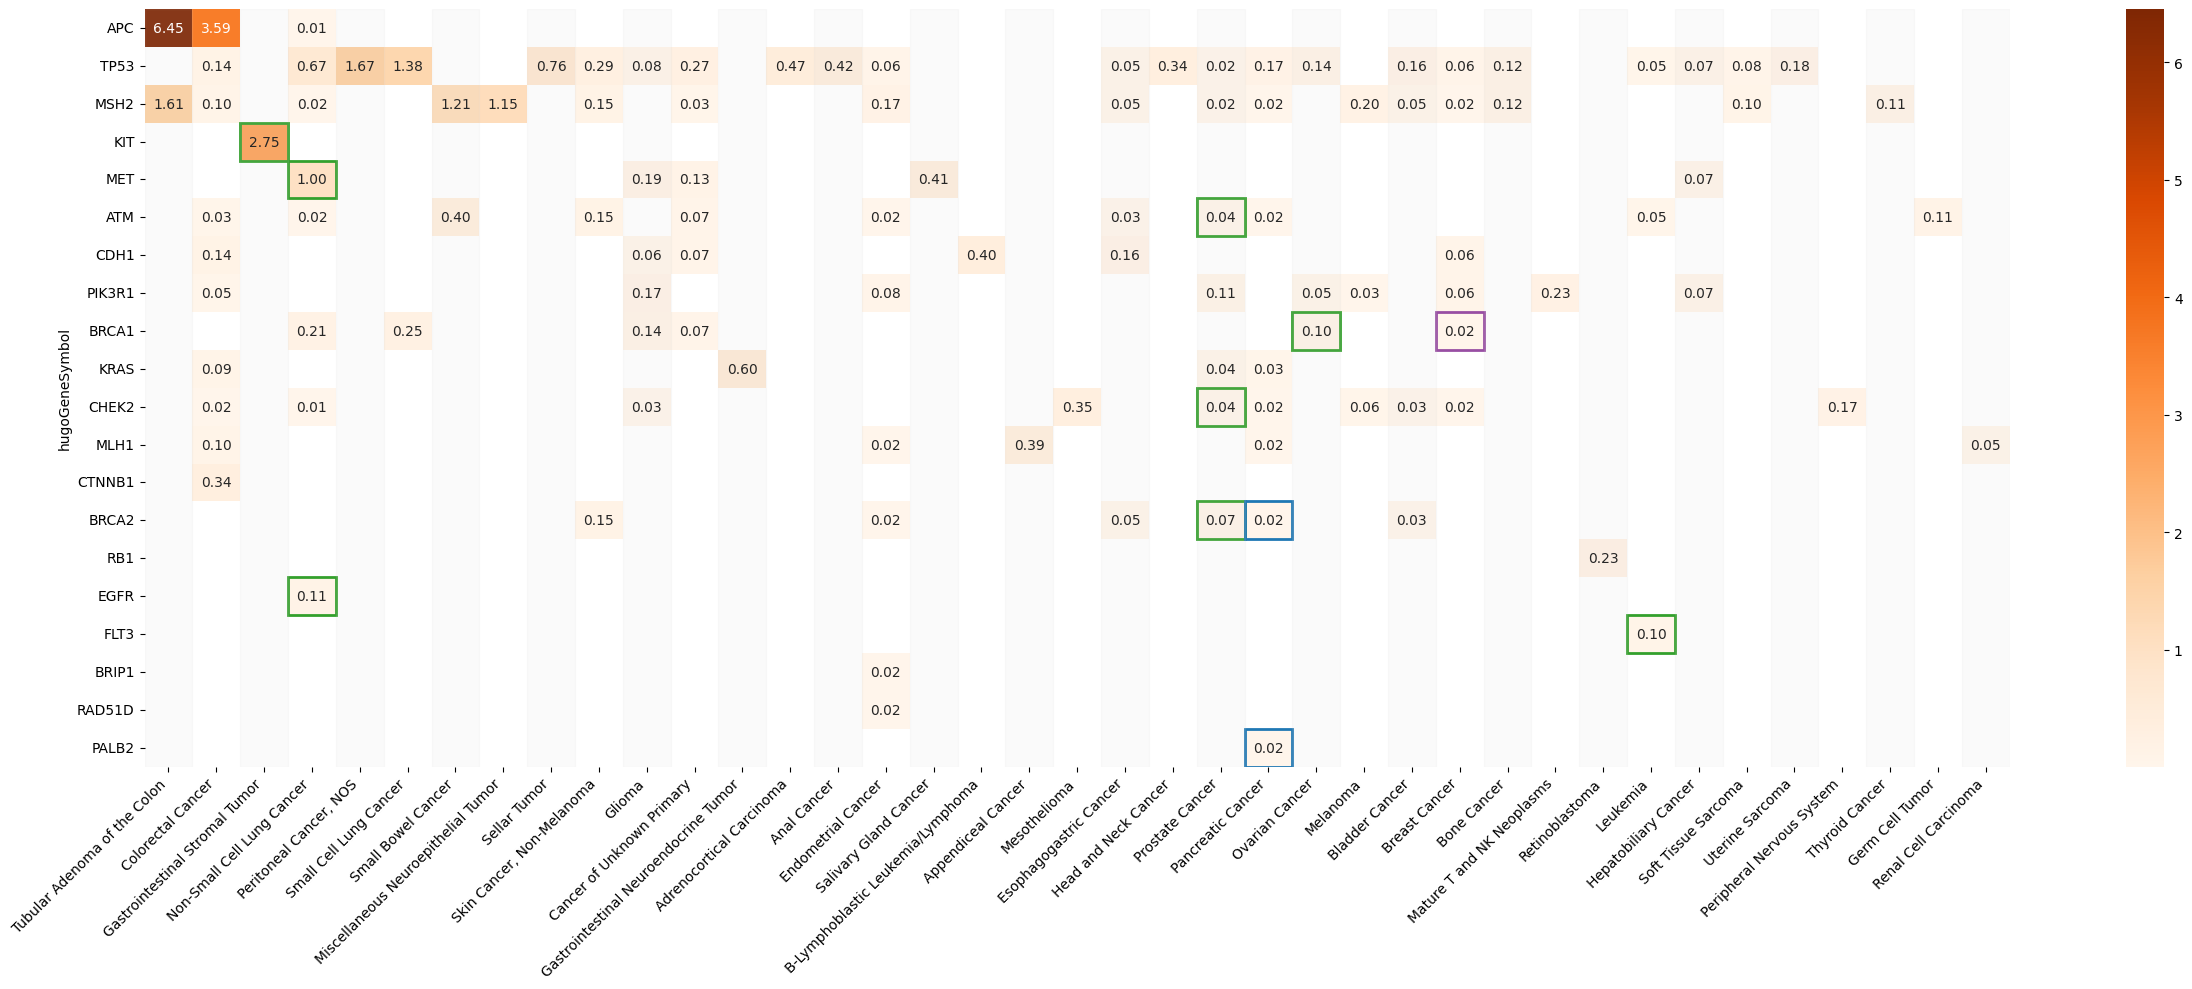

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

level_palette = {
    'Level 1': '#33A02C',
    'Level 2': '#1F78B4',
    'Level 3A': '#984EA3',
    'Level 3B': '#BE98CE',
    'Level 4': '#424242',
    'R1': '#EE3424',
    'R2': '#F79A92',
    'R3': '#FCD6D3' 
}

highlight_map = {
    'APC': {},
    'ATM': {'Prostate Cancer': 'Level 1'},
    'BAP1': {},
    'BRCA1': {
        'Prostate Cancer': 'Level 1',
        'Ovarian Cancer': 'Level 1',
        'Pancreatic Cancer': 'Level 2',
        'Breast Cancer': 'Level 3A'
    },
    'BRCA2': {
        'Prostate Cancer': 'Level 1',
        'Ovarian Cancer': 'Level 1',
        'Pancreatic Cancer': 'Level 2',
        'Uterine Sarcoma': 'Level 1',
        'Breast Cancer': 'Level 3A'
    },
    'BRIP1': {'Prostate Cancer': 'Level 1'},
    'CDH1': {},
    'CHEK2': {'Prostate Cancer': 'Level 1'},
    'CTNNB1': {},
    'EGFR': {
        'Non-Small Cell Lung Cancer': 'Level 1',
        'Esophagogastric Cancer': 'Level 3A',
        'Glioma': 'Level 4',
        'Colorectal Cancer': 'R2'
    },
    'F11': {},
    'FLT3': {'Leukemia': 'Level 1'},
    'KIT': {
        'Gastrointestinal Stromal Tumor': 'Level 1',
        'Mastocytosis': 'Level 1',
        'Melanoma': 'Level 2'
    },
    'KRAS': {},
    'MET': {'Non-Small Cell Lung Cancer': 'Level 1'},
    'MLH1': {'Prostate Cancer': 'Level 1'},
    'MSH2': {},
    'PALB2': {
        'Prostate Cancer': 'Level 1',
        'Pancreatic Cancer': 'Level 2'
    },
    'PIK3R1': {},
    'RAD51D': {'Prostate Cancer': 'Level 1'},
    'RB1': {},
    'TP53': {}
}

heatmap_data = grouped_df.filter(like='counts.CancerType')
heatmap_data.columns = [col.replace('counts.CancerType.', '') for col in heatmap_data.columns]
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) != 0]

for col in heatmap_data.columns:
    heatmap_data[col] = heatmap_data[col] * 100.0 / cancer_type_counts.loc[col]

heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
heatmap_data = heatmap_data[heatmap_data.sum(axis=0).sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(25, 10))
ax = sns.heatmap(heatmap_data, cmap='Oranges', annot=True, fmt='.2f', mask=heatmap_data == 0)

# Overlay colored boxes for matching gene × cancer_type × level
for row_idx, gene in enumerate(heatmap_data.index):
    for col_idx, cancer_type in enumerate(heatmap_data.columns):
        cell_value = heatmap_data.loc[gene, cancer_type]
        if cell_value == 0 or np.isnan(cell_value):
            continue

        highlight_entry = highlight_map.get(gene, {})
        if highlight_entry == 'all' or 'all' in highlight_entry:
            level = highlight_entry.get('all')
        else:
            level = highlight_entry.get(cancer_type)

        if level in level_palette:
            ax.add_patch(Rectangle(
                (col_idx, row_idx), 1, 1,
                fill=False,
                edgecolor=level_palette[level],
                linewidth=2
            ))

# Rotate long cancer type labels
plt.xticks(rotation=45, ha='right')

# Add vertical minor ticks at cell boundaries
ax.set_xticks(np.arange(len(heatmap_data.columns)) + 0.5, minor=True)
ax.grid(which='minor', axis='x', linestyle='-', color='lightgray', linewidth=0.5)
ax.tick_params(axis='x', which='minor', bottom=False)

# Add alternating column background stripes for readability
for idx in range(0, len(heatmap_data.columns), 2):
    ax.axvspan(idx, idx + 1, color='lightgrey', alpha=0.1)

# Add y-axis ticks for horizontal line support
ax.set_yticks(np.arange(len(heatmap_data.index)) + 0.5, minor=True)
ax.grid(which='minor', axis='y', linestyle='-', color='lightgray', linewidth=0.5)
ax.tick_params(axis='y', which='minor', left=False)

plt.tight_layout()
plt.show()



In [24]:
(grouped_df['total_variant_count'] > 0).sum()

22

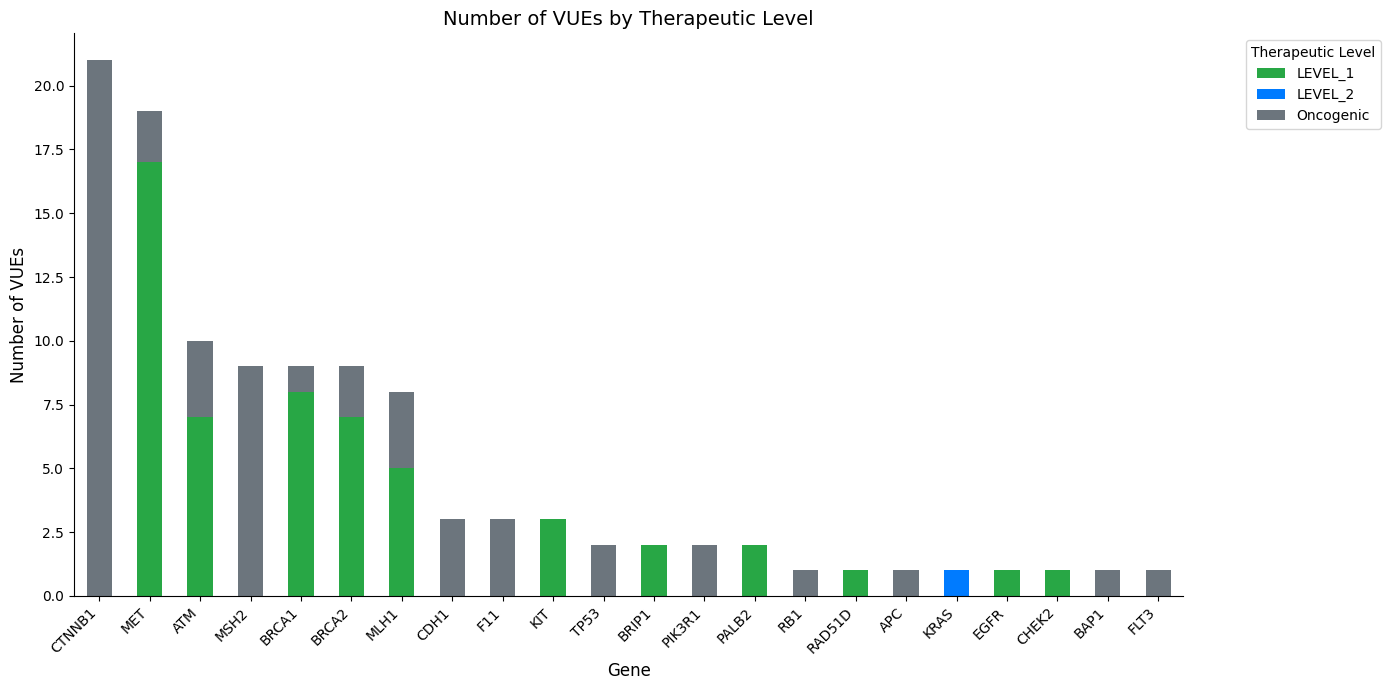

In [26]:
# Fill nulls with "Oncogenic"
result_df['therapeuticLevel'] = result_df['therapeuticLevel'].fillna('Oncogenic')

# Group by gene and therapeutic level → count VUEs
grouped_counts = result_df.groupby(['hugoGeneSymbol', 'therapeuticLevel']).size().unstack(fill_value=0)
# Sort genes by total number of VUEs
grouped_counts = grouped_counts.loc[grouped_counts.sum(axis=1).sort_values(ascending=False).index]

# Ensure consistent column order
level_palette = {
    'LEVEL_1': '#28a745',   # Green
    'LEVEL_2': '#007bff',   # Dark Blue
    'Oncogenic': '#6c757d'  # Gray
}
all_levels = list(level_palette.keys())
grouped_counts = grouped_counts.reindex(columns=all_levels, fill_value=0)

# Plot stacked bar chart
ax = grouped_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 7),
    color=[level_palette[level] for level in grouped_counts.columns]
)

# Plot formatting
plt.title(f"Number of VUEs by Therapeutic Level", fontsize=14)
plt.xlabel("Gene", fontsize=12)
plt.ylabel("Number of VUEs", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Therapeutic Level", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()
plt.tight_layout()
plt.show()





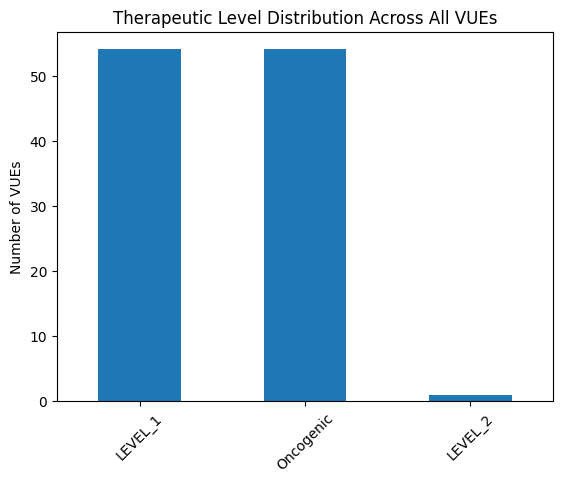

In [409]:
result_df['therapeuticLevel'].value_counts().plot(kind='bar')
plt.title("Therapeutic Level Distribution Across All VUEs")
plt.ylabel("Number of VUEs")
plt.xticks(rotation=45)
plt.show()

In [8]:
# create input for mutationmapper tool

# Create new DataFrame with the specified columns
new_data = {
    'Sample_ID': [],
    'Cancer_Type': [],
    'Chromosome': [],
    'Start_Position': [],
    'End_Position': [],
    'Reference_Allele': [],
    'Variant_Allele': []
}

# Fill in the new DataFrame
for location in result_df['genomicLocation']:
    try:
        chrom, start, end, ref, alt = location.split(',')
    except ValueError:
        continue
    new_data['Sample_ID'].append(f'Sample_{np.random.randint(1, 1000)}')
    new_data['Cancer_Type'].append(np.random.choice(['Lung', 'Breast', 'Colon', 'Prostate', 'Leukemia']))
    new_data['Chromosome'].append(chrom)
    new_data['Start_Position'].append(start)
    new_data['End_Position'].append(end)
    new_data['Reference_Allele'].append(ref)
    new_data['Variant_Allele'].append(alt)

new_df = pd.DataFrame(new_data)

# Copy the new DataFrame for pasting into MutationMapperTool
new_df.to_clipboard(index=False)
